# Exercise 4

### Setup

In [1]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from scipy.sparse import csc_matrix
from sklearn.datasets import make_moons, make_blobs

import qpsolvers as qps

### Question 1

##### Plot functions

In [2]:
plt.rcParams["figure.figsize"] = [15, 10]

def plot_data(X, y, colors=['blue', 'red']):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=ListedColormap(colors))

def plot_classifier(w, X, y, title):

    # Calc boundaries
    x_min = np.amin(X[:, 0])
    x_max = np.amax(X[:, 0])
    y_min = np.amin(X[:, 1])
    y_max = np.amax(X[:, 1])
    
    # Generate grid
    xx = np.linspace(x_min, x_max)
    yy = np.linspace(y_min, y_max)
    
    xx, yy = np.meshgrid(xx, yy)
    xy = np.c_[xx.ravel(), yy.ravel()] 

    z = np.c_[xy, np.ones(xy.shape[0])] @ w
    z = z.reshape(xx.shape)
    
    # Plot
    plt.title(title)
    plt.contour(xx, yy, z, levels=[-1, 0, 1], colors=['blue', 'black', 'red'], linestyles=['--','-', '--'])

def highlight_support_vectors(X, alpha, th):
    sv = np.argwhere(np.abs(alpha) > th).reshape(-1)
    plt.scatter(X[sv,0], X[sv,1], s=150, linewidth=2, facecolors='none', edgecolors='k')

##### Load the dataset

In [3]:
# Load
data = pd.read_csv('simple_classification.csv')
X, y = data.drop(columns=['y']), data['y']

# Add bias, correct labels
X = np.c_[X.to_numpy(), np.ones(len(X))]
y = y.transform(lambda x: x if x else -1).to_numpy()

##### SVM Primal Program

In [4]:
def svm_primal(X, y):
    N, n = X.shape

    # Objective
    P = np.eye(n)
    q = np.zeros(n)
    
    # Constraints
    G = -np.diag(y) @ X
    h = -np.ones(N)

    # Solution
    w = qps.solve_qp(csc_matrix(P), q, csc_matrix(G), h, solver="osqp")
    print(f"SVM Primal solution is: {w}")

    return w

SVM Primal solution is: [ 1.19553571  0.34700045 -6.52243901]


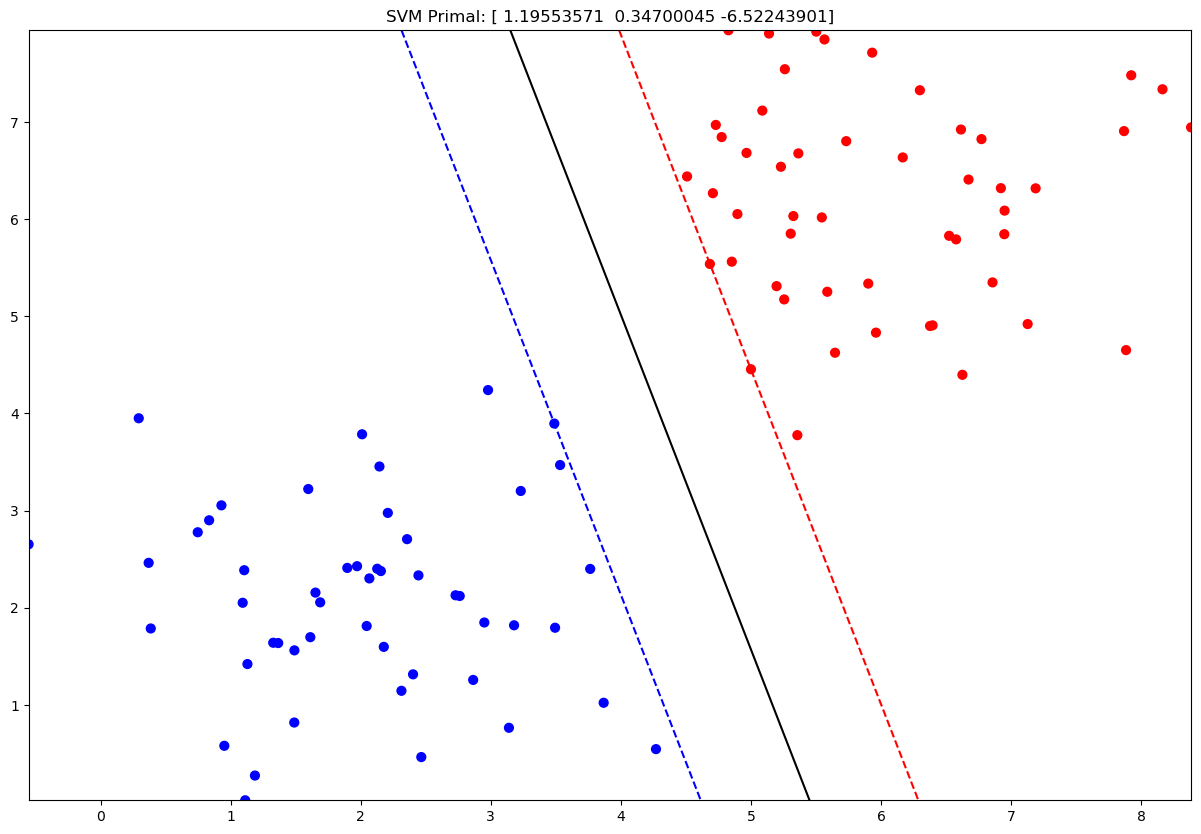

In [6]:
# solve using primal
w = svm_primal(X, y)

# Plot svm solution
plot_data(X, y)
plot_classifier(w, X, y, f"SVM Primal: {w}")

##### SVM Dual Program

In [7]:
def svm_dual(X, y):
    N = X.shape[0]

    # Objective
    GG = np.diag(y) @ X
    P = GG @ GG.T
    q = -np.ones(N)

    # Constraints
    G = -np.eye(N)
    h = np.zeros(N)

    # Solution
    alpha = qps.solve_qp(csc_matrix(P), q, csc_matrix(G), h, solver='osqp')
    w = GG.T @ alpha
    print(f"SVM Dual solution is: {w}")
    
    return alpha, w


SVM Dual solution is: [ 1.185658    0.35641661 -6.52274395]


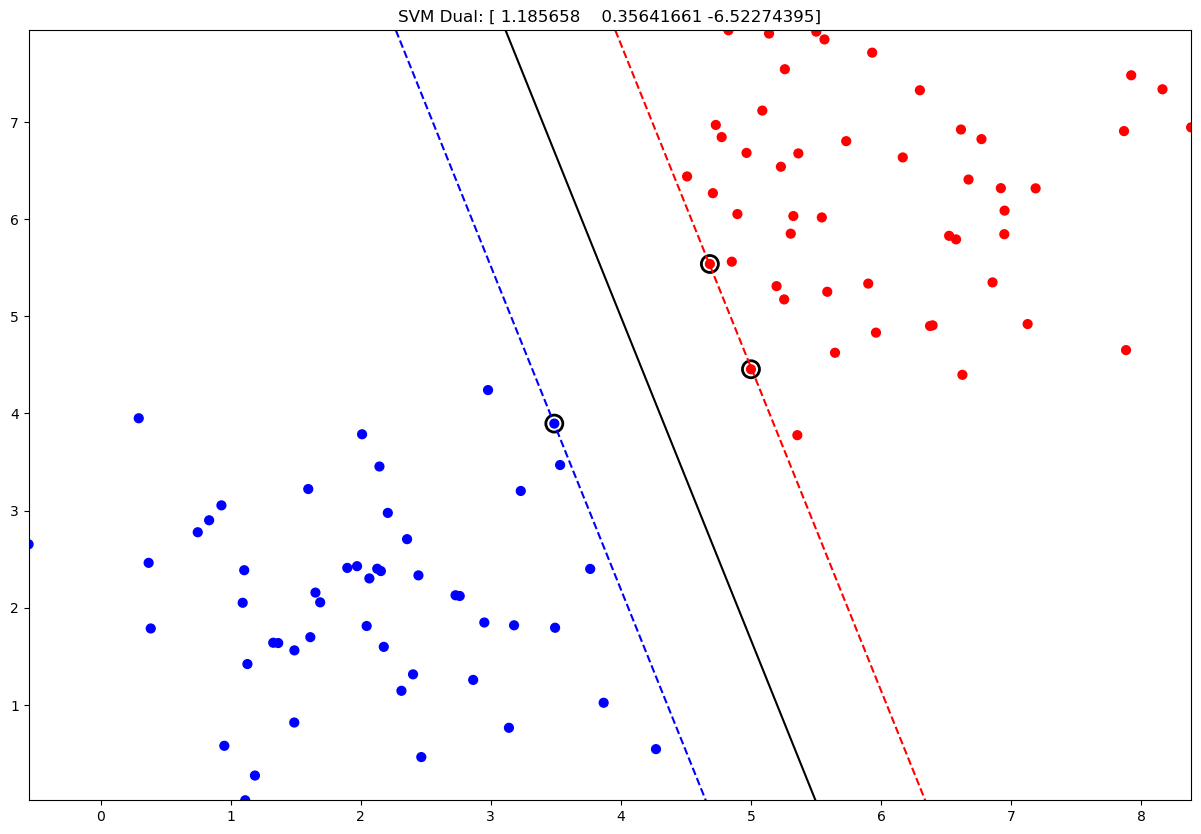

In [8]:
# solve using primal
a, w = svm_dual(X, y)

# Plot svm solution
plot_data(X, y)
plot_classifier(w, X, y, f"SVM Dual: {w}")
highlight_support_vectors(X, a, th=0.1)

### Question 2

In [9]:
def my_train_test_split(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
def plot_classifier_with_kernel(alpha, X, y, kernel, title):

    # Calc boundries
    x_min = np.amin(X[:, 0])
    x_max = np.amax(X[:, 0])
    y_min = np.amin(X[:, 1])
    y_max = np.amax(X[:, 1])
    
    # Build grid
    xx = np.linspace(x_min, x_max)
    yy = np.linspace(y_min, y_max)
    
    xx, yy = np.meshgrid(xx, yy)
    
    # Build countour using kernel
    N = X.shape[0]
    z = np.zeros(xx.shape)
    for i, j in itertools.product(range(xx.shape[0]), range(xx.shape[1])):
        z[i, j] = sum([
            y[k] * alpha[k] * kernel(X[k, :], np.array([xx[i, j], yy[i, j]])) 
            for k in range(N)
        ])

    # Plot            
    plt.title(title)
    plt.contour(xx, yy, z, levels=[-1, 0, 1], colors=['blue', 'black', 'red'], linestyles=['--','-', '--'])

In [11]:
def svm_dual_kernel(X, y, k):

    # Objective, using kernel
    N = X.shape[0]
    P = np.empty((N, N))
    for i, j in itertools.product(range(N), range(N)):
        P[i, j] = y[i] * y[j] * k(X[i, :], X[j, :])
    q = -np.ones(N)

    # Constraints
    G = -np.eye(N)
    h = np.zeros(N)

    # Solution
    alpha = qps.solve_qp(csc_matrix(P), q, csc_matrix(G), h, solver='osqp', max_iter=4000, verbose=False)
    
    return alpha

In [12]:
def simple_nonlin_classification_dual_kernel(kernel, k_name, sv_th):
    # Load data
    data = pd.read_csv('simple_nonlin_classification.csv')
    X, y = data.drop(columns=['y']).to_numpy(), data['y'].transform(lambda x: x if x else -1).to_numpy()

    # Split the data
    X_train, X_test, y_train, y_test = my_train_test_split(X, y)

    a = svm_dual_kernel(X_train, y_train, kernel)

    # Plot train data
    plot_data(X_train, y_train)
    plot_classifier_with_kernel(a, X_train, y_train, kernel, k_name)
    highlight_support_vectors(X_train, a, sv_th)

    # Plot test data
    plot_data(X_test, y_test, colors=['green', 'pink'])

In [19]:
def poly_kernel(degree):
    return lambda x, y: (1 + x.T @ y) ** degree, f"Poly(d = {degree})"

def rbf_kernel(gamma):
    return lambda x, y: np.exp(-gamma * (x - y).T @ (x - y)), f"RBF(g = {gamma})"



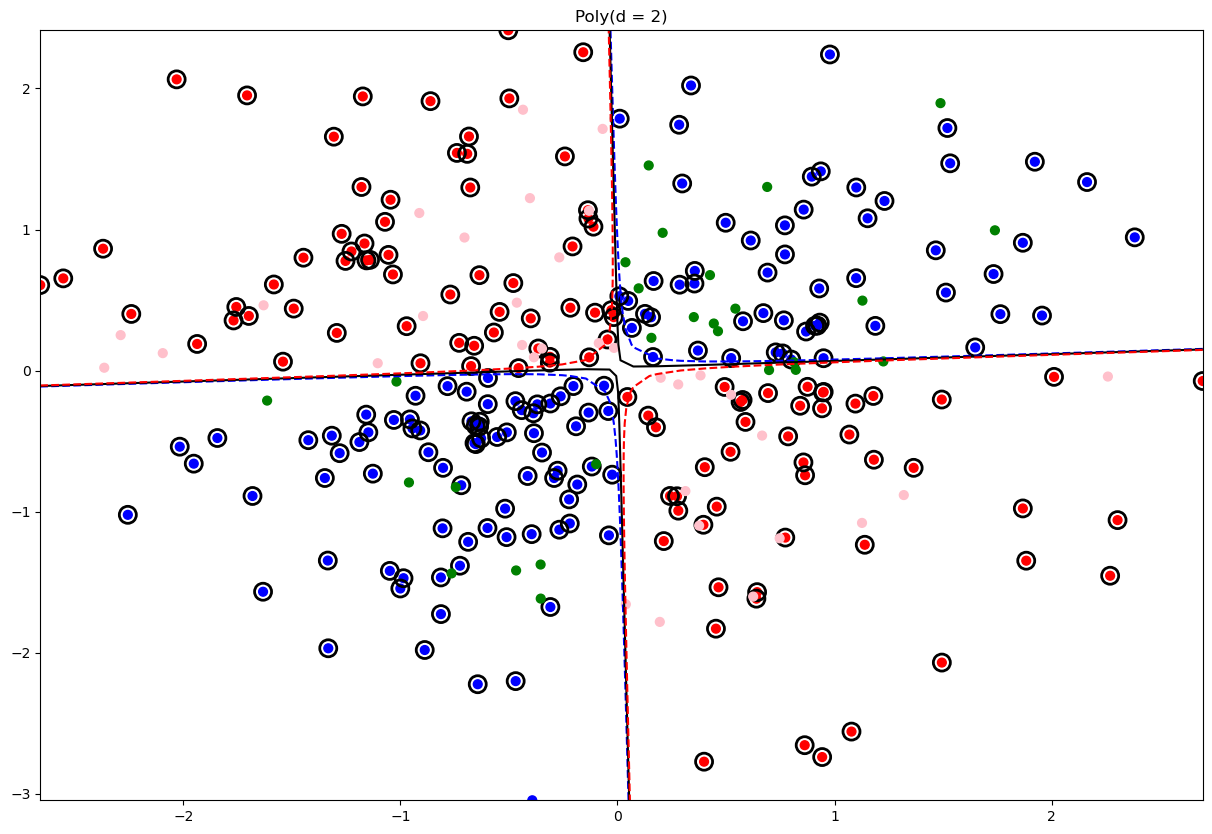

In [14]:
kernel, name = poly_kernel(degree=2)
simple_nonlin_classification_dual_kernel(kernel, name, sv_th=0.01)

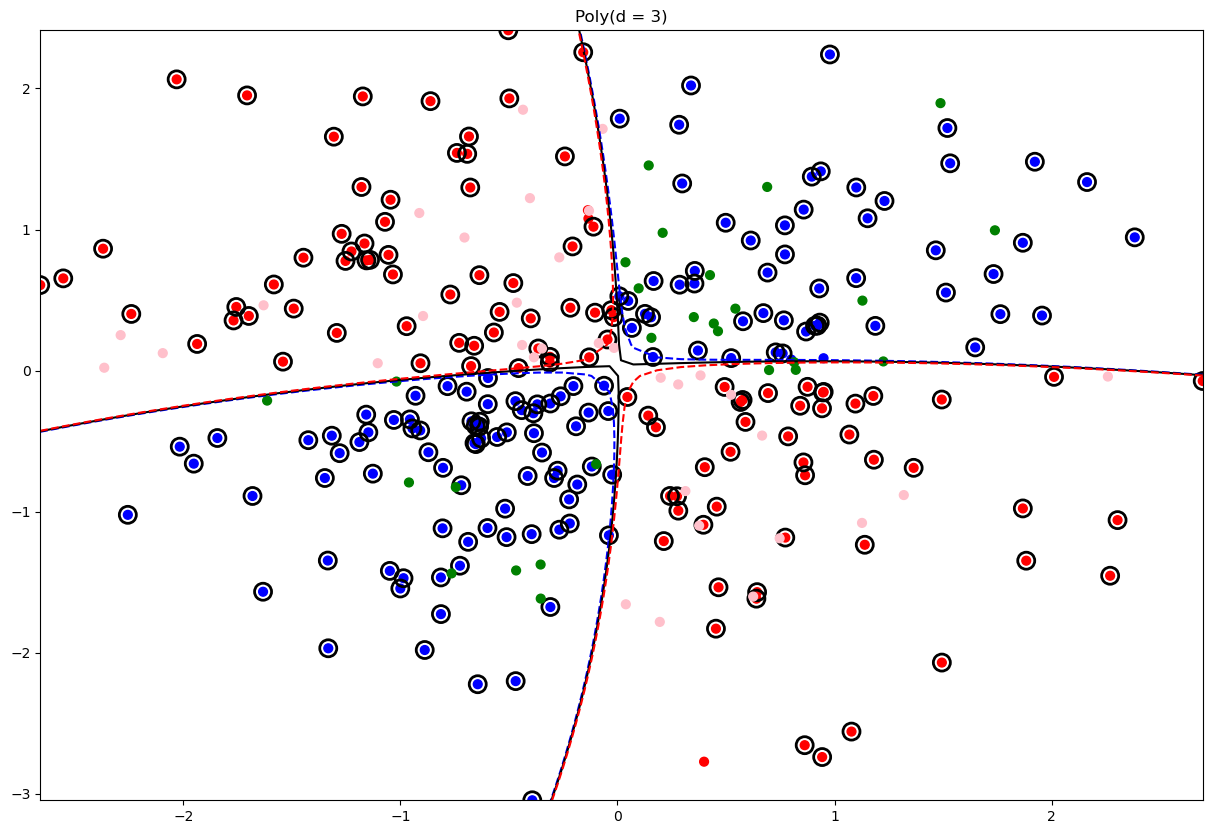

In [15]:
kernel, name = poly_kernel(degree=3)
simple_nonlin_classification_dual_kernel(kernel, name, sv_th=0.01)

In [ ]:
kernel, name = rbf_kernel(gamma=1)
simple_nonlin_classification_dual_kernel(kernel, name, sv_th=5)

In [ ]:
kernel, name = rbf_kernel(gamma=0.3)
simple_nonlin_classification_dual_kernel(kernel, name, sv_th=10)

c:\Users\OmriG\anaconda3\lib\site-packages\qpsolvers\solvers\osqp_.py:161: UserWarning: OSQP exited with status 'dual infeasible'
  warnings.warn(f"OSQP exited with status '{res.info.status}'")


TypeError: 'NoneType' object is not subscriptable

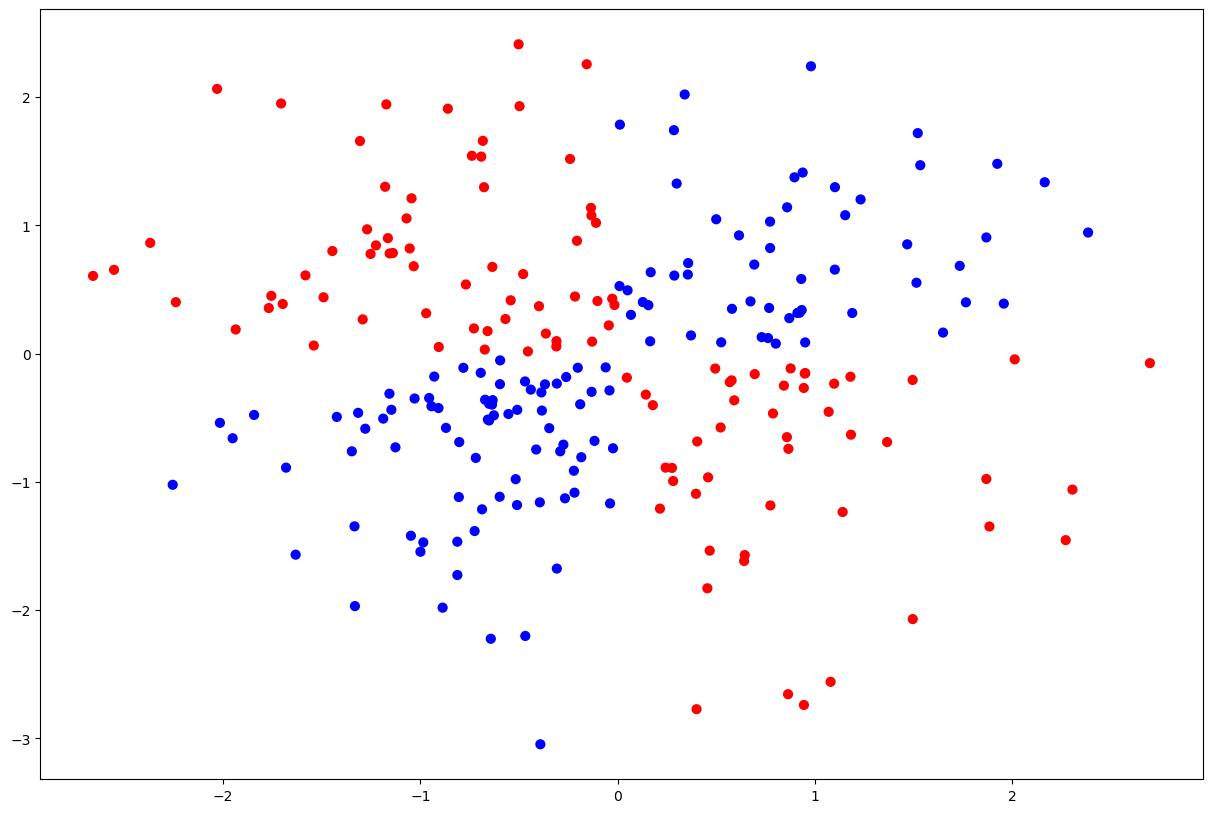

In [22]:
def sigmoid_kernel_omri(gamma):
    return lambda x, y: np.tanh(gamma * x.T @ y)

def sigmoid_kernel_shiraz(X, y, gamma=None):
    if gamma is None:
        gamma = 1.0 / X.shape[0]
    K = X.T @ y
    K *= gamma
    np.tanh(K + 1)
    return K

def sig_ker(gamma):
    return lambda x, y: sigmoid_kernel_shiraz(x, y, gamma) 

simple_nonlin_classification_dual_kernel(sig_ker(gamma=0.3), "", sv_th=0.01)

### Question 3

In [16]:
class SVMClassifier():
    def __init__(self, kernel='rbf', degree=3, C=1.0, gamma='scale'):

        
        # Input validation
        assert callable(kernel) or kernel in ['linear', 'poly', 'rbf', 'sigmoid'], "Invalid kernel"
        assert isinstance(degree, int), "Invalid degree"
        assert isinstance(C, float), "Invalid C"
        assert isinstance(gamma, float) or gamma in ['scale', 'auto'], "Invalid gamma"
        
        # Store inputs
        self.k = kernel
        self.d = degree
        self.C = C
        self.g = gamma

    def __gamma(self, X):
        if self.g == 'scale':
            return 1 / (X.shape[1] * X.var())
        elif self.g == 'auto':
            return 1 / X.shape[1]
        else:
            return self.g

    def __apply_kernel(self, X, y):
        from sklearn.metrics.pairwise import sigmoid_kernel

        # Select appropriate kernel
        gamma = self.__gamma(X)
        kernel = {
            'linear': lambda x, y: (1 + x.T @ y),
            'poly': lambda x, y: gamma * (1 + x.T @ y) ** self.d,
            'rbf': lambda x, y: np.exp(-gamma * (x - y).T @ (x - y)),
            'sigmoid': lambda x, y: sigmoid_kernel(np.array([x, y]))
        }[self.k]

        # Apply selected kernel
        N = X.shape[0]
        return kernel, f"{self.k} (gamma = {gamma}, degree = {self.d})", np.array([
            [
                y[i] * y[j] * kernel(X[i, :], X[j, :]) 
                for i in range(N)
            ]
            for j in range(N)
        ])

    def fit(self, X, y):

        N = X.shape[0]
        
        # Objective, using kernel
        k, k_name, P = self.__apply_kernel(X, y)
        q = -np.ones(N)

        # Constraints
        G = np.block([[-np.eye(N)], [np.eye(N)]])
        h = np.block([np.zeros(N), self.C * np.ones(N)])

        # Solution
        self.__alpha = qps.solve_qp(csc_matrix(P), q, csc_matrix(G), h, solver='osqp', max_iter=4000, verbose=False)

        # Plot solution
        plot_classifier_with_kernel(self.__alpha, X, y, k, k_name)

        return self

    def predict(self, X):
        # TODO
        return np.argmin(self.decision_function(X), axis=1)

    def decision_function(self, X):
        # TODO
        pass

    def score(self, X, y):
        return (self.predict(X) == y).sum() / len(y)

### Question 4

In [18]:
X, y = make_blobs(n_samples=500, centers=2, n_features=2, cluster_std=0.7, random_state=0)
y = 2 * y - 1

#plot_data(X, y)

svm_clf = SVMClassifier(kernel='sigmoid').fit(X, y)


TypeError: expected dimension <= 2 array or matrix